<a href="https://colab.research.google.com/github/emincingoz/Alzheimer-Diagnosis-App/blob/main/AlzheimerDiagnosisClassificationTemplate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, Rescaling
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import cv2
import os
%matplotlib inline

In [ ]:
!ls -al MyDrive/Bitirme

total 424158
-rw------- 1 root root 398281659 Oct 17 13:53 archive.zip
-rw------- 1 root root    271861 Nov  8 11:21 Bitirme.ipynb
drwx------ 2 root root      4096 Oct 31 18:23 dataset
-rw------- 1 root root  35779075 Oct 22 18:11 dataset1.zip


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("MyDrive/Bitirme/dataset1.zip", 'r')
zip_ref.extractall("/gdrive/MyDrive/Bitirme/dataset/")
zip_ref.close()

In [ ]:
os.chdir("/gdrive/MyDrive/Bitirme/")

In [ ]:
os.chdir("/gdrive/MyDrive/Bitirme/dataset/Alzheimer_s Dataset")

In [ ]:
num_skipped = 0


os.chdir("/gdrive/MyDrive/Bitirme/dataset/Alzheimer_s Dataset")
for class_name in('train', 'test'):
  for folder_name in('MildDemented', 'ModerateDemented','NonDemented', 'VeryMildDemented'):

    # add folder_name to PetImages
    folder_path = os.path.join(class_name, folder_name)
    
    # It keeps the files in folder_path as a list
    for fname in os.listdir(folder_path):
      fpath = os.path.join(folder_path, fname)

      try:
        # 'rb': Opens the file in binary format for reading
        fobj = open(fpath, 'rb')
        # tf.compat.as_bytes("JFIF") converts the string "JFIF" to bytes.
        # You could also just use b'JFIF'
        # fobj.peek(10) theoretically returns the first 10 bytes of the file
        is_jfif = tf.compat.as_bytes('JFIF') in fobj.peek(10)
      finally:
        fobj.close()

      if not is_jfif:
        num_skipped += 1

        # delete corrupted images
      # os.remove(fpath)

print('Deleted %d images' % num_skipped)

In [ ]:
img = cv2.imread('train/MildDemented/mildDem99.jpg') 
plt.imshow(img)

In [ ]:
img = cv2.imread('train/VeryMildDemented/verymildDem223.jpg') 
plt.imshow(img)

In [ ]:
img = cv2.imread('train/ModerateDemented/moderateDem9.jpg') 
plt.imshow(img)

In [ ]:
image_size = (255, 255)
batch_size = 32
labels = ['MildDemented', 'ModerateDemented','NonDemented', 'VeryMildDemented']

train_path = 'train'
test_path = 'test'
#val_path = '/content/drive/MyDrive/CNN/chest_xray/val'

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_ds = image_dataset_from_directory(train_path, 
                                        #validation_split = 0.2, 
                                        #subset = 'training', 
                                        image_size = image_size, 
                                        seed = 132,
                                        batch_size = batch_size, 
                                        color_mode = 'grayscale', 
                                        shuffle = True)

test_ds = image_dataset_from_directory(test_path, 
                                       #validation_split = 0.2,
                                       #subset = 'validation', 
                                       image_size = image_size, 
                                       seed = 132,
                                       batch_size = batch_size, 
                                       color_mode = 'grayscale', 
                                       shuffle = True)

Found 5121 files belonging to 4 classes.
Found 1279 files belonging to 4 classes.


In [ ]:
for images, labels in train_ds:
  print(images.shape)
  print(labels.shape)
  break

(32, 255, 255, 1)
(32,)


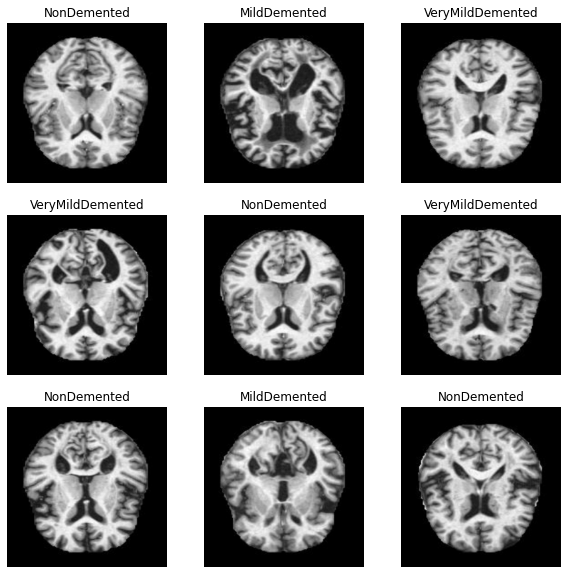

In [ ]:
class_names = train_ds.class_names

plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(np.squeeze(images[i].numpy().astype('uint8')), cmap = 'gray')
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:
x_train = tf.concat([x for x, y in train_ds], axis = 0)
y_train = tf.concat([y for x, y in train_ds], axis = 0)

x_test = tf.concat([x for x, y in test_ds], axis = 0)
y_test = tf.concat([y for x, y in test_ds], axis = 0)

tf.compat.v1.enable_eager_execution()

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5121, 255, 255, 1)
(5121,)
(1279, 255, 255, 1)
(1279,)


In [ ]:
type(x_train)

numpy.ndarray

In [ ]:
x_train = np.array(x_train).astype('uint8')
y_train = np.array(y_train).astype('uint8')

x_test = np.array(x_test).astype('uint8')
y_test = np.array(y_test).astype('uint8')

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5121, 255, 255, 1)
(5121,)
(1279, 255, 255, 1)
(1279,)


In [ ]:
type(x_train)

numpy.ndarray

Text(0.5, 1.0, 'VeryMildDemented')

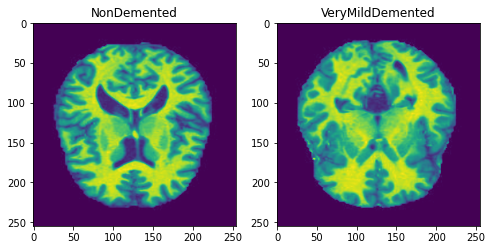

In [ ]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(x_train[5]))
plt.title(class_names[y_train[5]])

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(x_train[4000]))
plt.title(class_names[y_train[4000]])

In [ ]:
input_shape = image_size + (1,)
input_shape

(255, 255, 1)

In [ ]:
inputs = keras.Input(shape = input_shape)

x = layers.Rescaling(1./255)(inputs)
x

<KerasTensor: shape=(None, 255, 255, 1) dtype=float32 (created by layer 'rescaling')>

In [ ]:
y_train.size

5121

In [ ]:
y_train[2]

2

In [ ]:
zeros = 0
ones = 0
twos = 0
threes = 0

for i in range(y_train.size):
  if y_train[i] == 2: #nondemented
    zeros += 1
  elif y_train[i] == 3: #verymilddemented
    ones += 1
  elif y_train[i] == 0: #milddemented
    twos += 1
  elif y_train[i] == 1: #moderatedemented
    threes += 1

print(zeros)
print(ones)
print(twos)
print(threes)

2560
1792
717
52


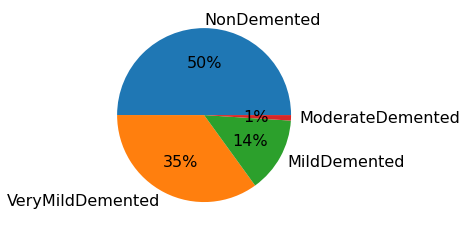

In [ ]:
plt.pie((zeros, ones,twos,threes), labels = ['NonDemented', 'VeryMildDemented','MildDemented', 'ModerateDemented'], autopct = '%.0f%%', textprops = {'fontsize':16})
plt.show()

<BarContainer object of 4 artists>

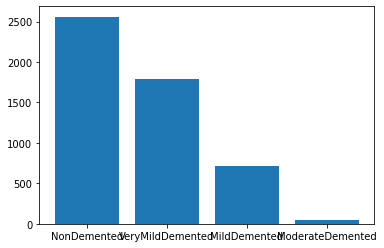

In [ ]:
plt.bar(['NonDemented', 'VeryMildDemented','MildDemented', 'ModerateDemented'], (zeros, ones,twos,threes))

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
def get_model(input_shape, num_classes):
  inputs = keras.Input(shape = input_shape)
  x = layers.Rescaling(1.0/255)(inputs)

  x = layers.Conv2D(filters = 128, kernel_size = 3)(x)
  #x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.MaxPool2D(pool_size = 3)(x)
  x = layers.Dropout(0.5)(x)


  x = layers.Conv2D(filters = 128, kernel_size = 3)(x)
  #x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters = 64, kernel_size = 3)(x)
  #x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.MaxPool2D(pool_size = 3)(x)
  x = layers.Dropout(0.5)(x)

  x = layers.Conv2D(filters = 64, kernel_size = 3)(x)
  #x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.MaxPool2D(pool_size = 3)(x)
  #x = layers.Dropout(0.6)(x)

  x = layers.Flatten()(x)
  #x = layers.Dropout(0.3)(x)

  x = layers.Dense(16, activation = 'relu')(x)
  #x = layers.BatchNormalization()(x)
  #x = layers.Dropout(0.6)(x)
  outputs = layers.Dense(num_classes, activation = 'sigmoid')(x)

  return keras.Model(inputs, outputs)

In [ ]:
model = get_model(input_shape = input_shape, num_classes = 4)

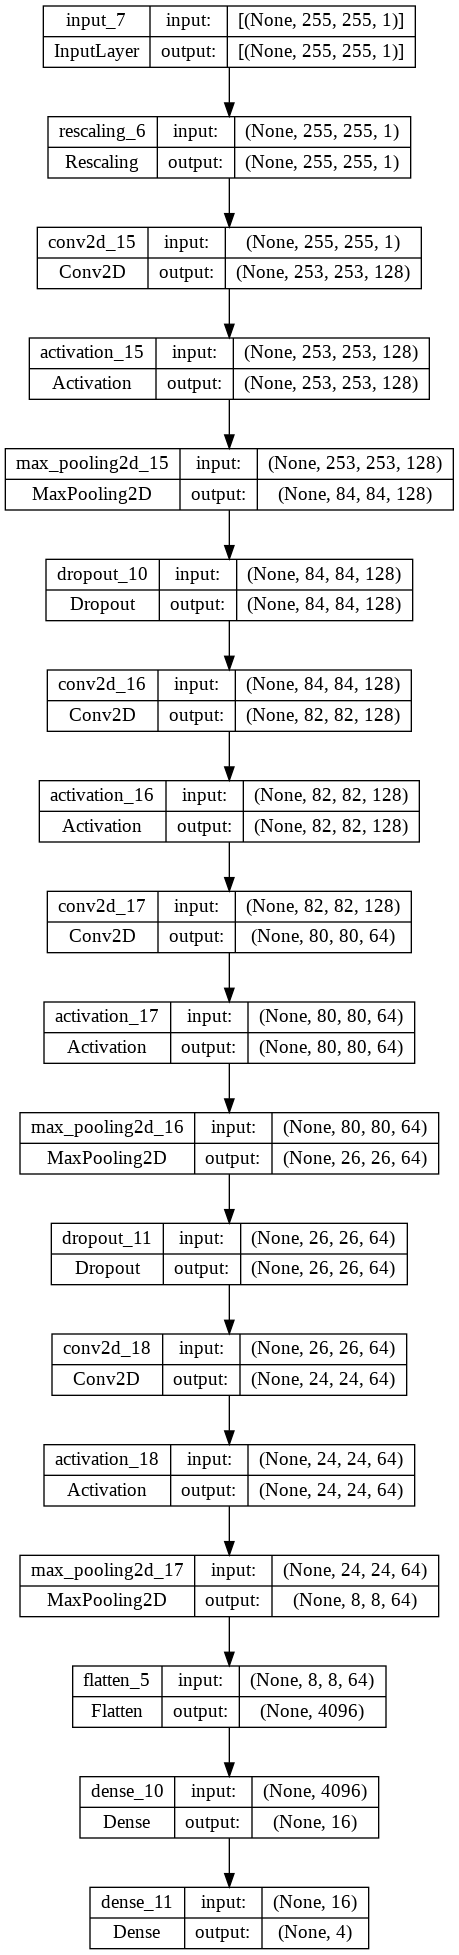

In [ ]:
keras.utils.plot_model(model, to_file = '/model_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
history = model.fit(train_ds,
                    #x = x_train, 
                    #y = y_train, 
                    epochs = 15, 
                    shuffle = True,  
                    # validation_data = (x_val, y_val) 
                    validation_data = test_ds)

Epoch 1/15
161/161 [==============================] - 26s 161ms/step - loss: 1.0073 - accuracy: 0.5124 - val_loss: 1.0271 - val_accuracy: 0.5262
Epoch 3/15
161/161 [==============================] - 26s 159ms/step - loss: 0.9755 - accuracy: 0.5390 - val_loss: 1.0042 - val_accuracy: 0.5293
Epoch 4/15
161/161 [==============================] - 26s 159ms/step - loss: 0.9319 - accuracy: 0.5688 - val_loss: 0.9693 - val_accuracy: 0.5536
Epoch 5/15
161/161 [==============================] - 26s 160ms/step - loss: 0.8686 - accuracy: 0.6079 - val_loss: 0.9110 - val_accuracy: 0.5770
Epoch 7/15
161/161 [==============================] - 26s 160ms/step - loss: 0.8385 - accuracy: 0.6218 - val_loss: 0.8907 - val_accuracy: 0.5817
Epoch 8/15
161/161 [==============================] - 26s 160ms/step - loss: 0.8193 - accuracy: 0.6274 - val_loss: 0.9049 - val_accuracy: 0.5950
Epoch 9/15
161/161 [==============================] - 26s 162ms/step - loss: 0.8002 - accuracy: 0.6385 - val_loss: 0.9183 - val_ac

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 255, 255, 1)]     0         
                                                                 
 rescaling_6 (Rescaling)     (None, 255, 255, 1)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 253, 253, 128)     1280      
                                                                 
 activation_15 (Activation)  (None, 253, 253, 128)     0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 84, 84, 128)      0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 84, 84, 128)       0         
                                                           

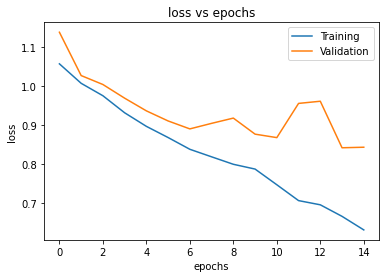

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss vs epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'], loc = 1)

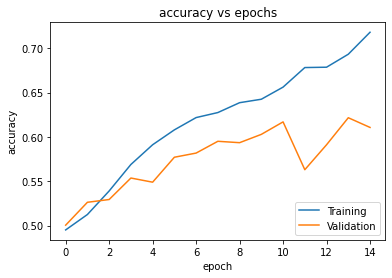

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy vs epochs')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Training', 'Validation'], loc = 4)

In [ ]:
model.save('../Models/prototype_model.h5')
#model = load_model('model.h5')

In [ ]:
result = model.evaluate(test_ds, verbose = 2)

40/40 - 3s - loss: 1.1294 - accuracy: 0.6497 - 3s/epoch - 67ms/step


In [ ]:
print('Test loss: ', result[0])
print('Test accuracy: ', result[1])

Test loss:  1.1293830871582031
Test accuracy:  0.6497263312339783


In [ ]:
y_pred = model.predict(x_test)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= .5] = 0

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(cm)
sns.heatmap(cm, cmap = 'Blues', annot = True)

40/40 [==============================] - 1s 25ms/step


ValueError: ignored